Intermodulation measurement program for Presto

Importing necessary libraries and connecting to measurement devices

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import os
import datetime
from nanodrivers.visa_drivers.signal_analyser import Anri
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


from presto.hardware import AdcFSample, AdcMode, DacFSample, DacMode
from presto import lockin, utils
# from presto.utils import ProgressBar

In [40]:
ADDRESS = "169.254.3.14"  # Presto's IP address

CONVERTER_CONFIGURATION = {
    "adc_mode": AdcMode.Mixed,  # Use digital downconversion.
    "adc_fsample": AdcFSample.G2,  # 4 GS/s sampling rate.
    "dac_mode": DacMode.Mixed42,  # Use digital upconversion.
    "dac_fsample": DacFSample.G10,  # 10 GS/s sampling rate.
}

In [41]:
anri = Anri()
anri.idn()

Connection exist: ANRITSU,MS2830A,6200847105,4.09.01



In [559]:
# ******************************
# *** define some parameters ***
# ******************************

INPUT_PORT = 5 # Somewhat confusingly, input is the listening port,
SG_PORT = 2
file_number = 1

DEL_OMEGA = 200
NR_STEPS = 80
DETUNING = 0.30e9
DF = 5 * 1e0 # Sampling Rate.
CENT_FREQ = 3.798 * 1e9
NCO_PHASE_OUT = 0*np.pi/180 # NCO output phase.
NCO_PHASE_IN = 0*np.pi/180 # NCO input phase.

OMEGA1 = -DEL_OMEGA/2
OMEGA2 = DEL_OMEGA/2

SG_FREQ_OUT = DETUNING + np.array([OMEGA1, OMEGA2])
FREQ_IN_MULT = np.mean(SG_FREQ_OUT)+np.linspace(OMEGA1*(NR_STEPS/2),OMEGA2*(NR_STEPS/2),NR_STEPS+1) # Lets gather data on multiple freequencies at the same time.
FREQ_IN = FREQ_IN_MULT
NR_FREQS_SG = len(SG_FREQ_OUT) # Number of output detunings, needed for method.
NR_FREQS_IN = len(FREQ_IN) # Same for input.
NR_MODES = NR_FREQS_IN/2
PHASE_SG = np.array([0 * np.pi/16, 0 * np.pi/16]) # Output group phase.
PHASE_SG_Q = PHASE_SG - np.pi/2
PHASE_IN = [0 * np.pi/16] # Input group phase.

DITHER = True 

NR_MEAS = 1 * 1e1 # Number of measured points both for raw and summed.
DAC_CURRENT = 40_500 # NCO current in micro amps, 40_500 is maximum and 2_250 is minimum.

#Parameters for frequency sweep
FREQ_SWEEP_SPAN = 2e6 #Span of the sweep
SWEEP_RES = 51 #nr of freq points sweeped
CENT_FREQ_ARR = np.flip(np.linspace(CENT_FREQ-FREQ_SWEEP_SPAN/2, CENT_FREQ+FREQ_SWEEP_SPAN/2, SWEEP_RES)) #Array for the central freqs of the sweep
NR_CENT_FREQ = len(CENT_FREQ_ARR)

#Parameters for power sweep
Amplitude, power_array = amplitudeArray(-15,-40,-5,-14)
NR_AMPLITUDE = len(Amplitude)
NR_AVE = 1

Mag = np.zeros((int(NR_AMPLITUDE),int(NR_CENT_FREQ),int(NR_STEPS+1)))
Pha = np.zeros((int(NR_AMPLITUDE),int(NR_CENT_FREQ),int(NR_STEPS+1)))

ff = NR_CENT_FREQ - 1
for f in CENT_FREQ_ARR:
    print(ff)
    NCO_FREQ = f - DETUNING # Numerically Controlled Oscillator (NCO) frequency. Can be defined separately for input and output. Riccardo says bad idea.

    with lockin.Lockin(ext_ref_clk=False, address=ADDRESS, **CONVERTER_CONFIGURATION) as lck:

        lck.hardware.set_adc_attenuation(INPUT_PORT, 0.0) # Attenuation at input, why would you though?
        lck.hardware.set_dac_current(SG_PORT, DAC_CURRENT) # Set NCO current for output.
        lck.hardware.configure_mixer(NCO_FREQ, out_ports=[SG_PORT], out_phase = NCO_PHASE_OUT, sync=False) # Configure input and output NCOs.
        lck.hardware.configure_mixer(2*NCO_FREQ+DETUNING, in_ports=INPUT_PORT,  in_phase = NCO_PHASE_IN, sync=True) # Configure input and
        
        lck.set_phase_reset(False) # Reset phase of ig and og at the start of every lockin cycle.
        lck.set_dither(DITHER, SG_PORT) # Adds dither to the output ports when set True.

        freq_sg, df = lck.tune(SG_FREQ_OUT,DF) # Tunes the sampling rate in such a way that each lockin cycle has n full wavelengths.

        sgg = lck.add_output_group(ports=SG_PORT, nr_freq=NR_FREQS_SG) # Create output group.
        sgg.set_frequencies(freq_sg) # Set output group detunings.
        sgg.set_phases(phases=PHASE_SG, phases_q=PHASE_SG_Q) # Set output group phases.
        freq_in, df = lck.tune(FREQ_IN,DF) # Previous was output group, this one is input.
        lck.set_df(df) # Set Sampling rate according to the tuning.


        ig = lck.add_input_group(INPUT_PORT, nr_freq=NR_FREQS_IN) # Create input group.
        ig.set_frequencies(freq_in) # Set input group detunings.
        ig.set_phases(phases=PHASE_IN) # Set input group phases. Rotating this equals basis transformation.

        #lck.hardware.set_inv_sinc([SG_PORT],2)

        lck.apply_settings() # For the previously given changes to take effect, the settings need to be applied.
        lck.hardware.sleep(.2) # Sleep for 0.1 second as outputs are turned on and off during apply.

        jj = 0
        for AMP in Amplitude:
            # Set amplitude of the IF for experiment
            lck.hardware.blank_output(ports=[SG_PORT], state=False) # Reverse blanking outputs for excited state data.
            lck.hardware.sleep(0.1, False) # Sleep for a short duration to make sure device is in steady state.
            sgg.set_amplitudes([AMP,AMP]) # Set output group amplitudes.
            sgg.set_phases(phases=PHASE_SG, phases_q=PHASE_SG_Q) # Set output group phases.
            lck.apply_settings() # For the previously given changes to take effect, the settings need to be applied.
            lck.hardware.sleep(0.1) # Sleep for 0.1 second as outputs are turned on and off during apply.

            # pixel_dict = lck.get_pixels(NR_MEAS, fir_coeffs=coeffs) # Measure a number of pixels: Measure IQ data.
            pixel_dict = lck.get_pixels(NR_MEAS) # Measure a number of pixels: Measure IQ data.
            freq, pixel_i, pixel_q = pixel_dict[INPUT_PORT] # Get IQ data.
            IQ1, IQ2 = utils.untwist_downconversion(pixel_i, pixel_q) # Separate lower and higher sidebands.

            for ii in range(NR_FREQS_IN):
                Mag[jj,ff,ii] = np.mean(np.absolute(IQ2[:,ii]))
                Pha[jj,ff,ii] = np.mean(np.angle(IQ2[:,ii], deg=False))
            jj = jj + 1

        ff = ff - 1

        sgg.set_amplitudes(np.zeros(NR_FREQS_SG))
        lck.set_trigger_out(0)
        lck.apply_settings()
        lck.hardware.sleep(0.1) # Sleep for 0.1 second as outputs are turned on and off during apply.
print('Measurement successful!')

50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
Measurement successful!


In [560]:
now = datetime.datetime.now()  
folder = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\IMS_summer_pro\Presto data'
file = r'Presto_IMS_2Omega_[-15 to -40]_' + now.strftime(r'%Y%m%d%H%M%S') + '.mat'
file_name = folder +'\\' + file

# sio.savemat('DataIntermodulationDistortion_' + now.strftime("%Y_%m_%d_%H_%M_%S") + '.mat' , 
sio.savemat(file_name, 
            {'mag': Mag, 'pha': Pha, 'freq': FREQ_IN_MULT, 'sweep_cent_freq': CENT_FREQ*2, 'span': 2*FREQ_SWEEP_SPAN, 'power': power_array})
print('File download successful!')

File download successful!


In [563]:
#WIDE SWEEP

# ******************************
# *** define some parameters ***
# ******************************

INPUT_PORT = 5 # Somewhat confusingly, input is the listening port,
SG_PORT = 2
file_number = 1

DEL_OMEGA = 200
NR_STEPS = 80
DETUNING = 0.30e9
DF = 1 * 1e0 # Sampling Rate.
CENT_FREQ = 3.798 * 1e9
NCO_PHASE_OUT = 0*np.pi/180 # NCO output phase.
NCO_PHASE_IN = 0*np.pi/180 # NCO input phase.

OMEGA1 = -DEL_OMEGA/2
OMEGA2 = DEL_OMEGA/2

SG_FREQ_OUT = DETUNING + np.array([OMEGA1, OMEGA2])
FREQ_IN_MULT = np.mean(SG_FREQ_OUT)+np.linspace(OMEGA1*(NR_STEPS/2),OMEGA2*(NR_STEPS/2),NR_STEPS+1) # Lets gather data on multiple freequencies at the same time.
FREQ_IN = FREQ_IN_MULT
NR_FREQS_SG = len(SG_FREQ_OUT) # Number of output detunings, needed for method.
NR_FREQS_IN = len(FREQ_IN) # Same for input.
NR_MODES = NR_FREQS_IN/2
PHASE_SG = np.array([0 * np.pi/16, 0 * np.pi/16]) # Output group phase.
PHASE_SG_Q = PHASE_SG - np.pi/2
PHASE_IN = [0 * np.pi/16] # Input group phase.

DITHER = True 

NR_MEAS = 1 * 1e2 # Number of measured points both for raw and summed.
DAC_CURRENT = 40_500 # NCO current in micro amps, 40_500 is maximum and 2_250 is minimum.

#Parameters for frequency sweep
FREQ_SWEEP_SPAN = 6e6 #Span of the sweep
SWEEP_RES = 201 #nr of freq points sweeped
CENT_FREQ_ARR = np.flip(np.linspace(CENT_FREQ-FREQ_SWEEP_SPAN/2, CENT_FREQ+FREQ_SWEEP_SPAN/2, SWEEP_RES)) #Array for the central freqs of the sweep
NR_CENT_FREQ = len(CENT_FREQ_ARR)

#Parameters for power sweep
Amplitude, power_array = amplitudeArray(-15,-50,-5,-14)
NR_AMPLITUDE = len(Amplitude)
NR_AVE = 1

Mag = np.zeros((int(NR_AMPLITUDE),int(NR_CENT_FREQ),int(NR_STEPS+1)))
Pha = np.zeros((int(NR_AMPLITUDE),int(NR_CENT_FREQ),int(NR_STEPS+1)))

ff = NR_CENT_FREQ - 1
for f in CENT_FREQ_ARR:
    print(ff)
    NCO_FREQ = f - DETUNING # Numerically Controlled Oscillator (NCO) frequency. Can be defined separately for input and output. Riccardo says bad idea.

    with lockin.Lockin(ext_ref_clk=False, address=ADDRESS, **CONVERTER_CONFIGURATION) as lck:

        lck.hardware.set_adc_attenuation(INPUT_PORT, 0.0) # Attenuation at input, why would you though?
        lck.hardware.set_dac_current(SG_PORT, DAC_CURRENT) # Set NCO current for output.
        lck.hardware.configure_mixer(NCO_FREQ, in_ports=INPUT_PORT, out_ports=[SG_PORT], 
                                     in_phase = NCO_PHASE_IN, out_phase = NCO_PHASE_OUT, sync=True) # Configure input and output NCOs.

        lck.set_phase_reset(False) # Reset phase of ig and og at the start of every lockin cycle.
        lck.set_dither(DITHER, SG_PORT) # Adds dither to the output ports when set True.

        freq_sg, df = lck.tune(SG_FREQ_OUT,DF) # Tunes the sampling rate in such a way that each lockin cycle has n full wavelengths.

        sgg = lck.add_output_group(ports=SG_PORT, nr_freq=NR_FREQS_SG) # Create output group.
        sgg.set_frequencies(freq_sg) # Set output group detunings.
        sgg.set_phases(phases=PHASE_SG, phases_q=PHASE_SG_Q) # Set output group phases.
        freq_in, df = lck.tune(FREQ_IN,DF) # Previous was output group, this one is input.
        lck.set_df(df) # Set Sampling rate according to the tuning.


        ig = lck.add_input_group(INPUT_PORT, nr_freq=NR_FREQS_IN) # Create input group.
        ig.set_frequencies(freq_in) # Set input group detunings.
        ig.set_phases(phases=PHASE_IN) # Set input group phases. Rotating this equals basis transformation.

        #lck.hardware.set_inv_sinc([SG_PORT],2)

        lck.apply_settings() # For the previously given changes to take effect, the settings need to be applied.
        lck.hardware.sleep(.2) # Sleep for 0.1 second as outputs are turned on and off during apply.

        jj = 0
        for AMP in Amplitude:
            # Set amplitude of the IF for experiment
            lck.hardware.blank_output(ports=[SG_PORT], state=False) # Reverse blanking outputs for excited state data.
            lck.hardware.sleep(0.1, False) # Sleep for a short duration to make sure device is in steady state.
            sgg.set_amplitudes([AMP,AMP]) # Set output group amplitudes.
            sgg.set_phases(phases=PHASE_SG, phases_q=PHASE_SG_Q) # Set output group phases.
            lck.apply_settings() # For the previously given changes to take effect, the settings need to be applied.
            lck.hardware.sleep(0.1) # Sleep for 0.1 second as outputs are turned on and off during apply.

            # pixel_dict = lck.get_pixels(NR_MEAS, fir_coeffs=coeffs) # Measure a number of pixels: Measure IQ data.
            pixel_dict = lck.get_pixels(NR_MEAS) # Measure a number of pixels: Measure IQ data.
            freq, pixel_i, pixel_q = pixel_dict[INPUT_PORT] # Get IQ data.
            IQ1, IQ2 = utils.untwist_downconversion(pixel_i, pixel_q) # Separate lower and higher sidebands.

            for ii in range(NR_FREQS_IN):
                Mag[jj,ff,ii] = np.mean(np.absolute(IQ2[:,ii]))
                Pha[jj,ff,ii] = np.mean(np.angle(IQ2[:,ii], deg=False))
            jj = jj + 1

        ff = ff - 1

        sgg.set_amplitudes(np.zeros(NR_FREQS_SG))
        lck.set_trigger_out(0)
        lck.apply_settings()
        lck.hardware.sleep(0.1) # Sleep for 0.1 second as outputs are turned on and off during apply.
print('Measurement successful!')

200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
Measurement successful!


In [564]:
now = datetime.datetime.now()  
folder = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\IMS_summer_pro\Presto data'
file = r'Presto_IMS_LOWNOISE_[-15 to -40]_' + now.strftime(r'%Y%m%d%H%M%S') + '.mat'
file_name = folder +'\\' + file

# sio.savemat('DataIntermodulationDistortion_' + now.strftime("%Y_%m_%d_%H_%M_%S") + '.mat' , 
sio.savemat(file_name, 
            {'mag': Mag, 'pha': Pha, 'freq': FREQ_IN_MULT, 'sweep_cent_freq': CENT_FREQ, 'span': FREQ_SWEEP_SPAN, 'power': power_array})
print('File download successful!')

File download successful!


In [561]:
# LOWNOISE

# ******************************
# *** define some parameters ***
# ******************************

INPUT_PORT = 5 # Somewhat confusingly, input is the listening port,
SG_PORT = 2
file_number = 1

DEL_OMEGA = 200
NR_STEPS = 80
DETUNING = 0.30e9
DF = 1 * 1e0 # Sampling Rate.
CENT_FREQ = 3.798 * 1e9
NCO_PHASE_OUT = 0*np.pi/180 # NCO output phase.
NCO_PHASE_IN = 0*np.pi/180 # NCO input phase.

OMEGA1 = -DEL_OMEGA/2
OMEGA2 = DEL_OMEGA/2

SG_FREQ_OUT = DETUNING + np.array([OMEGA1, OMEGA2])
FREQ_IN_MULT = np.mean(SG_FREQ_OUT)+np.linspace(OMEGA1*(NR_STEPS/2),OMEGA2*(NR_STEPS/2),NR_STEPS+1) # Lets gather data on multiple freequencies at the same time.
FREQ_IN = FREQ_IN_MULT
NR_FREQS_SG = len(SG_FREQ_OUT) # Number of output detunings, needed for method.
NR_FREQS_IN = len(FREQ_IN) # Same for input.
NR_MODES = NR_FREQS_IN/2
PHASE_SG = np.array([0 * np.pi/16, 0 * np.pi/16]) # Output group phase.
PHASE_SG_Q = PHASE_SG - np.pi/2
PHASE_IN = [0 * np.pi/16] # Input group phase.

DITHER = True 

NR_MEAS = 1 * 1e2 # Number of measured points both for raw and summed.
DAC_CURRENT = 40_500 # NCO current in micro amps, 40_500 is maximum and 2_250 is minimum.

#Parameters for frequency sweep
FREQ_SWEEP_SPAN = 3e6 #Span of the sweep
SWEEP_RES = 201 #nr of freq points sweeped
CENT_FREQ_ARR = np.flip(np.linspace(CENT_FREQ-FREQ_SWEEP_SPAN/2, CENT_FREQ+FREQ_SWEEP_SPAN/2, SWEEP_RES)) #Array for the central freqs of the sweep
NR_CENT_FREQ = len(CENT_FREQ_ARR)

#Parameters for power sweep
Amplitude, power_array = amplitudeArray(-20,-32,-2,-14)
NR_AMPLITUDE = len(Amplitude)
NR_AVE = 1

Mag = np.zeros((int(NR_AMPLITUDE),int(NR_CENT_FREQ),int(NR_STEPS+1)))
Pha = np.zeros((int(NR_AMPLITUDE),int(NR_CENT_FREQ),int(NR_STEPS+1)))

ff = NR_CENT_FREQ - 1
for f in CENT_FREQ_ARR:
    print(ff)
    NCO_FREQ = f - DETUNING # Numerically Controlled Oscillator (NCO) frequency. Can be defined separately for input and output. Riccardo says bad idea.

    with lockin.Lockin(ext_ref_clk=False, address=ADDRESS, **CONVERTER_CONFIGURATION) as lck:

        lck.hardware.set_adc_attenuation(INPUT_PORT, 0.0) # Attenuation at input, why would you though?
        lck.hardware.set_dac_current(SG_PORT, DAC_CURRENT) # Set NCO current for output.
        lck.hardware.configure_mixer(NCO_FREQ, in_ports=INPUT_PORT, out_ports=[SG_PORT], 
                                     in_phase = NCO_PHASE_IN, out_phase = NCO_PHASE_OUT, sync=True) # Configure input and output NCOs.

        lck.set_phase_reset(False) # Reset phase of ig and og at the start of every lockin cycle.
        lck.set_dither(DITHER, SG_PORT) # Adds dither to the output ports when set True.

        freq_sg, df = lck.tune(SG_FREQ_OUT,DF) # Tunes the sampling rate in such a way that each lockin cycle has n full wavelengths.

        sgg = lck.add_output_group(ports=SG_PORT, nr_freq=NR_FREQS_SG) # Create output group.
        sgg.set_frequencies(freq_sg) # Set output group detunings.
        sgg.set_phases(phases=PHASE_SG, phases_q=PHASE_SG_Q) # Set output group phases.
        freq_in, df = lck.tune(FREQ_IN,DF) # Previous was output group, this one is input.
        lck.set_df(df) # Set Sampling rate according to the tuning.


        ig = lck.add_input_group(INPUT_PORT, nr_freq=NR_FREQS_IN) # Create input group.
        ig.set_frequencies(freq_in) # Set input group detunings.
        ig.set_phases(phases=PHASE_IN) # Set input group phases. Rotating this equals basis transformation.

        #lck.hardware.set_inv_sinc([SG_PORT],2)

        lck.apply_settings() # For the previously given changes to take effect, the settings need to be applied.
        lck.hardware.sleep(.2) # Sleep for 0.1 second as outputs are turned on and off during apply.

        jj = 0
        for AMP in Amplitude:
            # Set amplitude of the IF for experiment
            lck.hardware.blank_output(ports=[SG_PORT], state=False) # Reverse blanking outputs for excited state data.
            lck.hardware.sleep(0.1, False) # Sleep for a short duration to make sure device is in steady state.
            sgg.set_amplitudes([AMP,AMP]) # Set output group amplitudes.
            sgg.set_phases(phases=PHASE_SG, phases_q=PHASE_SG_Q) # Set output group phases.
            lck.apply_settings() # For the previously given changes to take effect, the settings need to be applied.
            lck.hardware.sleep(0.1) # Sleep for 0.1 second as outputs are turned on and off during apply.

            # pixel_dict = lck.get_pixels(NR_MEAS, fir_coeffs=coeffs) # Measure a number of pixels: Measure IQ data.
            pixel_dict = lck.get_pixels(NR_MEAS) # Measure a number of pixels: Measure IQ data.
            freq, pixel_i, pixel_q = pixel_dict[INPUT_PORT] # Get IQ data.
            IQ1, IQ2 = utils.untwist_downconversion(pixel_i, pixel_q) # Separate lower and higher sidebands.

            for ii in range(NR_FREQS_IN):
                Mag[jj,ff,ii] = np.mean(np.absolute(IQ2[:,ii]))
                Pha[jj,ff,ii] = np.mean(np.angle(IQ2[:,ii], deg=False))
            jj = jj + 1

        ff = ff - 1

        sgg.set_amplitudes(np.zeros(NR_FREQS_SG))
        lck.set_trigger_out(0)
        lck.apply_settings()
        lck.hardware.sleep(0.1) # Sleep for 0.1 second as outputs are turned on and off during apply.
print('Measurement successful!')

200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
Measurement successful!


In [562]:
now = datetime.datetime.now()  
folder = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\IMS_summer_pro\Presto data'
file = r'Presto_IMS_LOWNOISE_[-20 to -30]_' + now.strftime(r'%Y%m%d%H%M%S') + '.mat'
file_name = folder +'\\' + file

# sio.savemat('DataIntermodulationDistortion_' + now.strftime("%Y_%m_%d_%H_%M_%S") + '.mat' , 
sio.savemat(file_name, 
            {'mag': Mag, 'pha': Pha, 'freq': FREQ_IN_MULT, 'sweep_cent_freq': CENT_FREQ, 'span': FREQ_SWEEP_SPAN, 'power': power_array})
print('File download successful!')

File download successful!


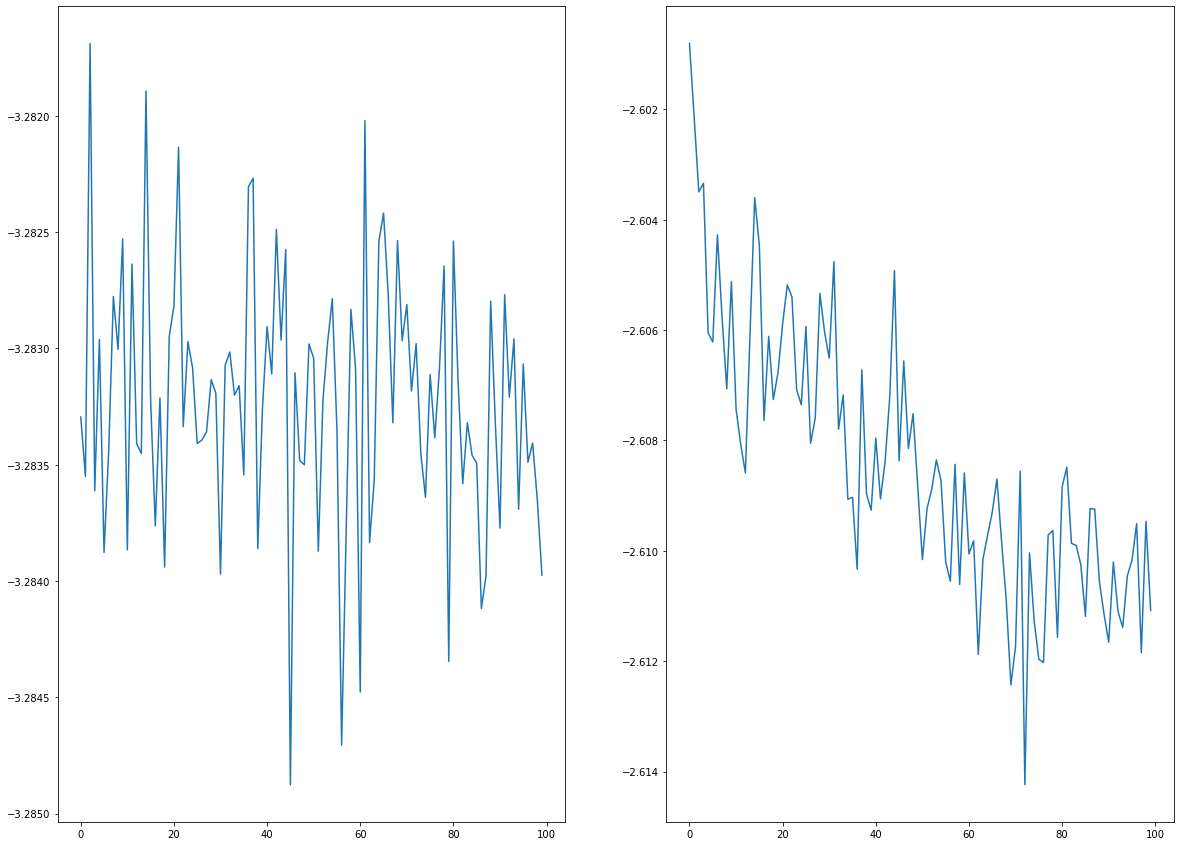

In [344]:
fig, ax = plt.subplots(1, 2, figsize=(20,15))
ax[0].plot(np.log10(np.absolute(IQ2[:,37])))
ax[1].plot(np.angle(IQ2[:,37]))

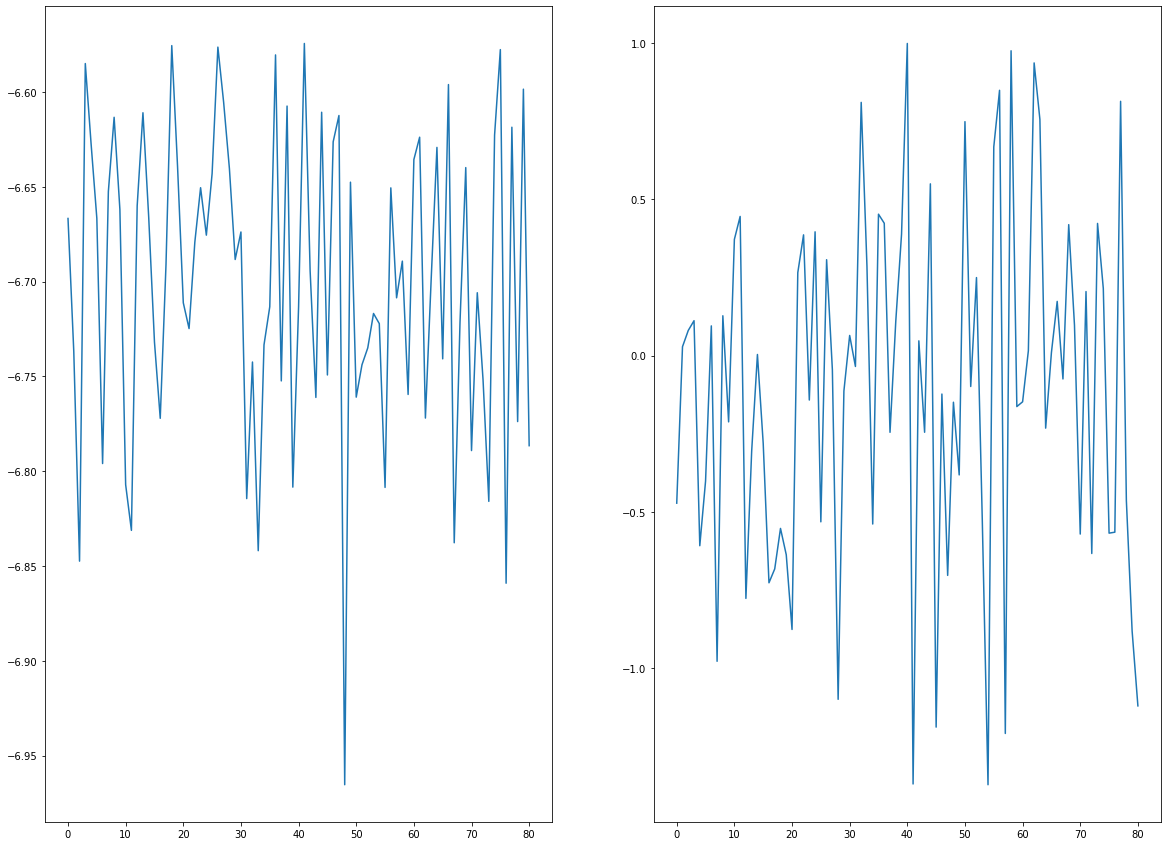

In [558]:
fig, ax = plt.subplots(1, 2, figsize=(20,15))
ax[0].plot(np.log10(Mag[0,0,:]))
ax[1].plot(Pha[0,0,:])

In [547]:
with lockin.Lockin(ext_ref_clk=False, address=ADDRESS, **CONVERTER_CONFIGURATION) as lck:
    sgg.set_amplitudes([0,0])
    lck.set_trigger_out(0)
    lck.apply_settings()

In [5]:
def inputConv(DBM, ZERO_LEVEL): #[Amplification] = dB
    AMP = 0.5*np.power(10,(abs(ZERO_LEVEL)+DBM)/20)
    return AMP

In [6]:
def amplitudeArray(start_pow, end_pow, pow_inc, zero_level):
    amp_span = int((abs(end_pow) - abs(start_pow)) / abs(pow_inc))
    amp_arr = np.zeros(amp_span+1)
    p_arr = np.zeros(amp_span+1)
    p = start_pow
    i = 0
    while p >= end_pow:
        amp_arr[i] = inputConv(p, zero_level)
        p_arr[i] = p
        i = i + 1
        p = p + pow_inc
    return amp_arr, p_arr

In [7]:
print(amplitudeArray(-15,-40,-1,-14))

(array([0.44562547, 0.39716412, 0.35397289, 0.31547867, 0.28117066,
       0.25059362, 0.2233418 , 0.19905359, 0.17740669, 0.15811388,
       0.14091915, 0.12559432, 0.11193606, 0.09976312, 0.08891397,
       0.07924466, 0.07062688, 0.06294627, 0.05610092, 0.05      ,
       0.04456255, 0.03971641, 0.03539729, 0.03154787, 0.02811707,
       0.02505936]), array([-15., -16., -17., -18., -19., -20., -21., -22., -23., -24., -25.,
       -26., -27., -28., -29., -30., -31., -32., -33., -34., -35., -36.,
       -37., -38., -39., -40.]))


In [13]:
print(len(amplitudeArray(-15,-40,-0.5,-14)[1]))

51
